In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

In [2]:
order_products_train_df = pd.read_csv("instacart_data/order_products__train.csv")
order_products_prior_df = pd.read_csv("instacart_data/order_products__prior.csv")
orders_df = pd.read_csv("instacart_data/orders.csv")
products_df = pd.read_csv("instacart_data/products.csv")
aisles_df = pd.read_csv("instacart_data/aisles.csv")
departments_df = pd.read_csv("instacart_data/departments.csv")

## Checking out the files & Autopsy of data

In [3]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [4]:
print (len(order_products_train_df['order_id'].unique()))
print (len(order_products_train_df['product_id'].unique()))

order_products_train_df.count()

131209
39123


order_id             1384617
product_id           1384617
add_to_cart_order    1384617
reordered            1384617
dtype: int64

In [5]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
print (len(order_products_train_df['order_id'].unique()))
print (len(order_products_train_df['product_id'].unique()))

order_products_prior_df.count()

131209
39123


order_id             32434489
product_id           32434489
add_to_cart_order    32434489
reordered            32434489
dtype: int64

## How many products were reordered from prior and train dataset? 

In [7]:
order_products_prior_df.reordered.sum() / order_products_prior_df.reordered.count()

0.58969746679221613

In [8]:
order_products_train_df.reordered.sum() / order_products_train_df.reordered.count()

0.59859441275096292

In [9]:
order_products_prior_df['reordered'].value_counts()

1    19126536
0    13307953
Name: reordered, dtype: int64

In [10]:
order_products_train_df['reordered'].value_counts()

1    828824
0    555793
Name: reordered, dtype: int64

We observe that almost 59% of products were reordered!

In [11]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [12]:
print (orders_df['eval_set'].unique())
orders_df.count()

['prior' 'train' 'test']


order_id                  3421083
user_id                   3421083
eval_set                  3421083
order_number              3421083
order_dow                 3421083
order_hour_of_day         3421083
days_since_prior_order    3214874
dtype: int64

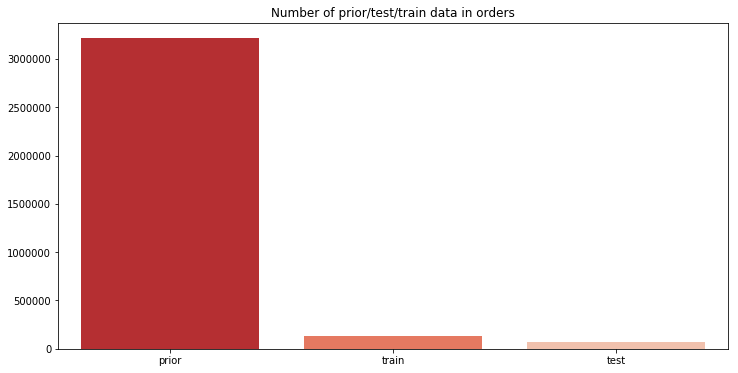

In [13]:
count = orders_df['eval_set'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(count.index, count.values,palette="Reds_r")
plt.title('Number of prior/test/train data in orders', fontsize=12)
plt.show()

In [14]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

So there are 206,209 customers in total. Out of which, the last purchase of 131,209 customers are given as train set and we need to predict for the rest 75,000 customers.

## When Do People Generally Order?

Text(0.5,1,'Frequency of orders by hours of the day')

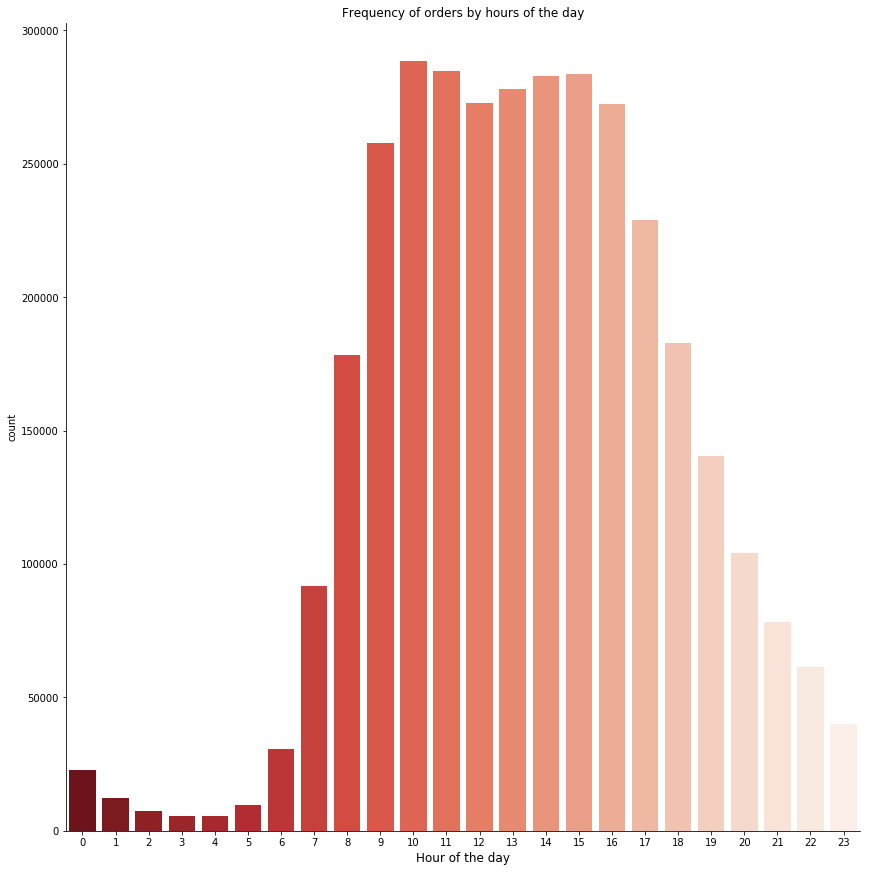

In [15]:
x = orders_df['order_hour_of_day'].index
sns.factorplot(x=x, data=orders_df['order_hour_of_day'], kind="count",palette="Reds_r", size=12)
plt.xlabel('Hour of the day', fontsize=12)
plt.title('Frequency of orders by hours of the day')

## At What Day Of The Week People Order?

Text(0.5,1,'Frequency of orders by week')

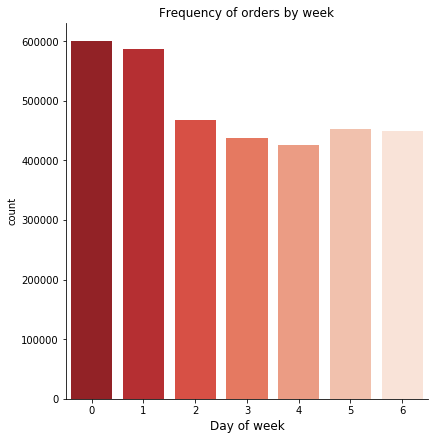

In [16]:
g = sns.factorplot(x=orders_df['order_dow'].index, data=orders_df['order_dow'], kind="count",palette="Reds_r", size=6)
plt.xlabel('Day of week', fontsize=12)
plt.title('Frequency of orders by week')

## What is the idealist hour and day of the purchase?

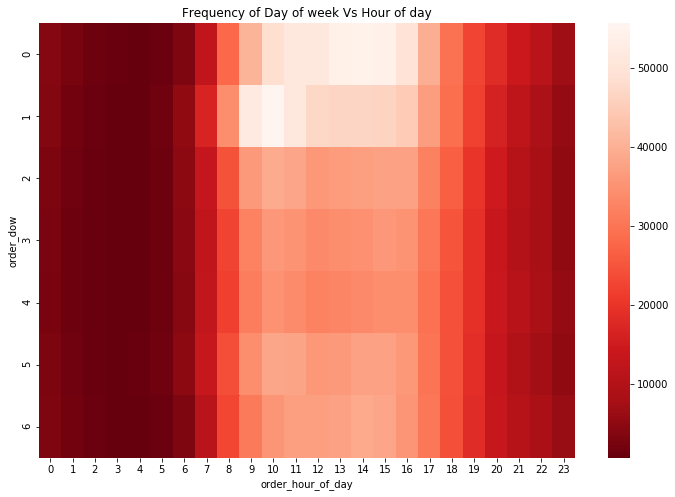

In [17]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,8))
sns.heatmap(grouped_df, cmap="Reds_r" )
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

## How many orders users generally made?
So there are no orders less than 4 and is max capped at 100 as given in the data page.

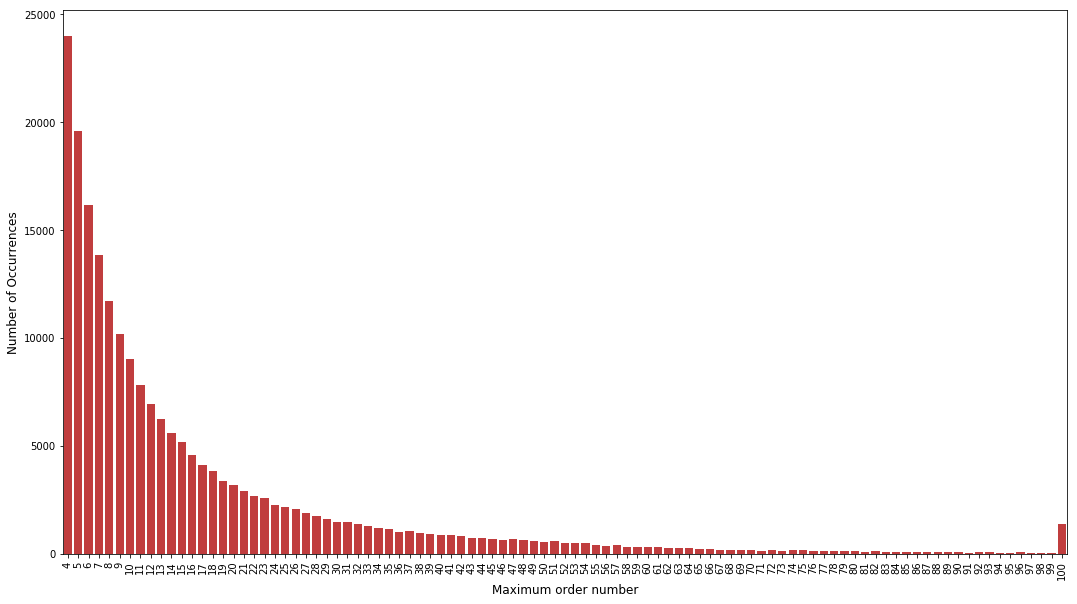

In [18]:
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(18,10))
sns.barplot(cnt_srs.index, cnt_srs.values, color=color[3])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

## At what interval do customers purchase again?

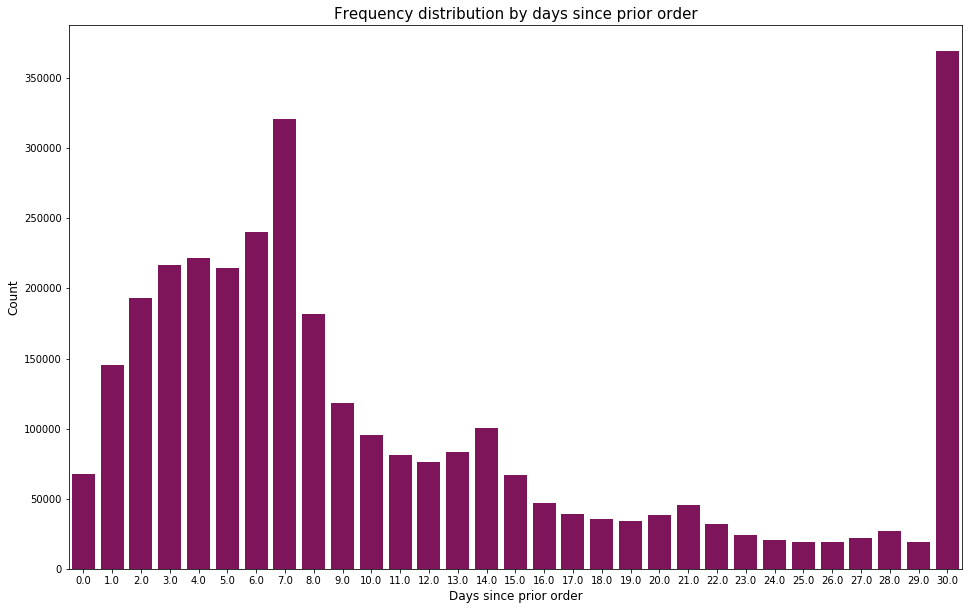

In [19]:
plt.figure(figsize=(16,10))
sns.countplot(x="days_since_prior_order", data=orders_df, color='#90035f')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

## Which item do people put into the cart first?

In [20]:
# productsCount = order_products_train_df["product_id"].value_counts().to_frame()
# productsCount["count"] = productsCount.product_id
# productsCount["product_id"] = productsCount.index

# productsCountFirst = order_products_train_df[order_products_train_df["add_to_cart_order"]==1]["product_id"].value_counts().to_frame()
# productsCountFirst["reordered_count"] = productsCountFirst.product_id
# productsCountFirst["product_id"] = productsCountFirst.index
# productCountFirstMerged = pd.merge(productsCount,productsCountFirst,how="left",on="product_id").sort_values(by="count",ascending=False)
# productCountFirstMerged["first_ordered_ratio"] = productCountFirstMerged["reordered_count"]/productCountFirstMerged["count"]
# productCountFirstMerged.sort_values(by="first_ordered_ratio",ascending=False,inplace=True)
# firstMerged = pd.merge(productCountFirstMerged,products,how="left",on="product_id")


# fig,ax = plt.subplots()
# fig.set_size_inches(18,10)
# sns.barplot(data=firstMerged[firstMerged["count"]>10].head(30),x="product_name",y="first_ordered_ratio",color="#34495e",ax=ax,orient="v")
# ax.set(xlabel='Product Names',ylabel="Count",title="Top Reordered Products")
# ax.set_ylim(0.4,.7)
# plt.xticks(rotation=90)

# firstMerged.head(10)

In [21]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [22]:
print (len(products_df['product_name'].unique()))
products_df.count()

49688


product_id       49688
product_name     49688
aisle_id         49688
department_id    49688
dtype: int64

In [23]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [24]:
aisles_df.count()

aisle_id    134
aisle       134
dtype: int64

In [25]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [26]:
print ('Total items:', departments_df.count())
print ('Unique items:', departments_df['department'].unique())

Total items: department_id    21
department       21
dtype: int64
Unique items: ['frozen' 'other' 'bakery' 'produce' 'alcohol' 'international' 'beverages'
 'pets' 'dry goods pasta' 'bulk' 'personal care' 'meat seafood' 'pantry'
 'breakfast' 'canned goods' 'dairy eggs' 'household' 'babies' 'snacks'
 'deli' 'missing']


## Show time!

In [27]:
order_products_prior_df.shape

(32434489, 4)

In [28]:
order_products_prior_df.reordered.sum()

19126536

In [29]:
order_products_prior_df.reordered.count()

32434489

## Merging data

Merge the products, department and aisle columns

In [30]:
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


## Best Selling products

In [31]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


## Most popular products in Aisle

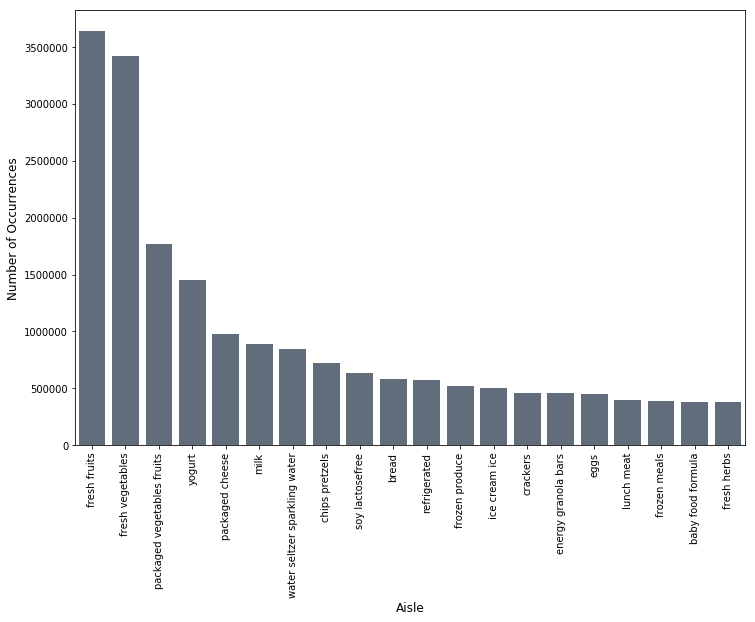

In [32]:
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='#34495e')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

## Most popular products in Department

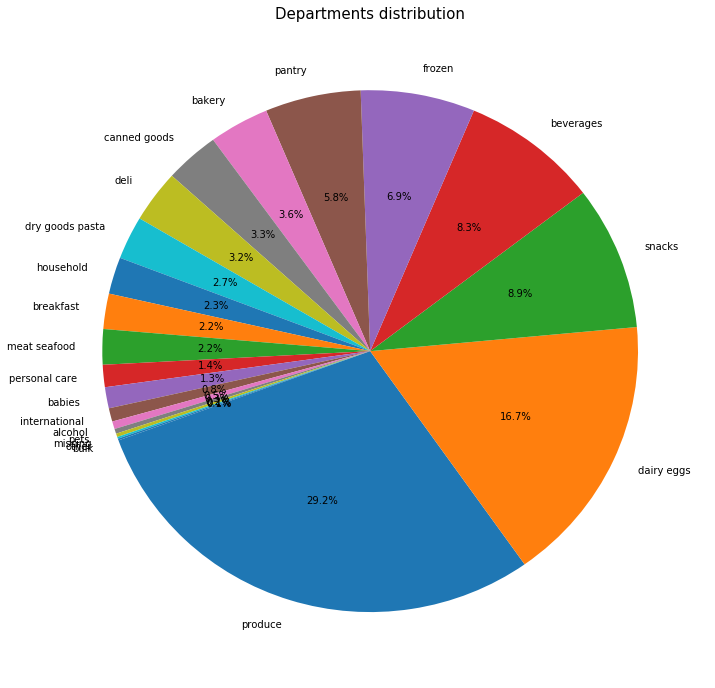

In [33]:
plt.figure(figsize=(12,12))
temp_series = order_products_prior_df['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

### Produce is the largest department.

## Reordered Products - Department

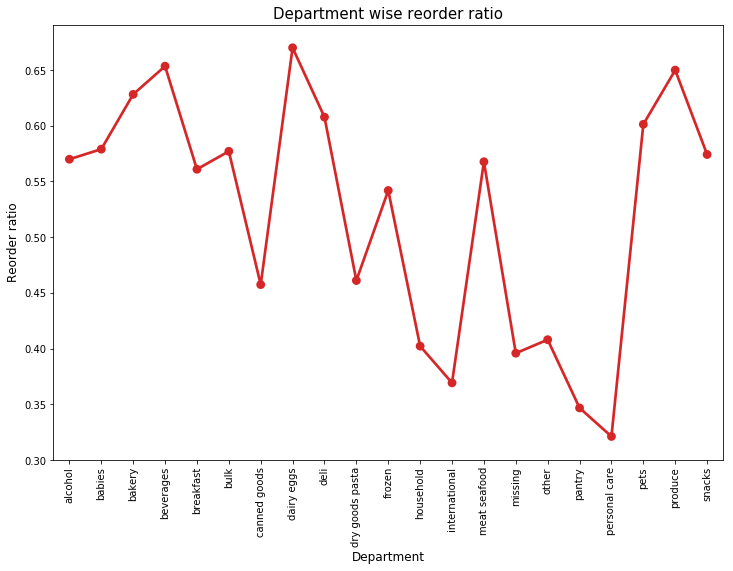

In [34]:
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

### **Personal care has lowest reorder ratio and dairy eggs have highest reorder ratio.**

## Reorder - Aisle

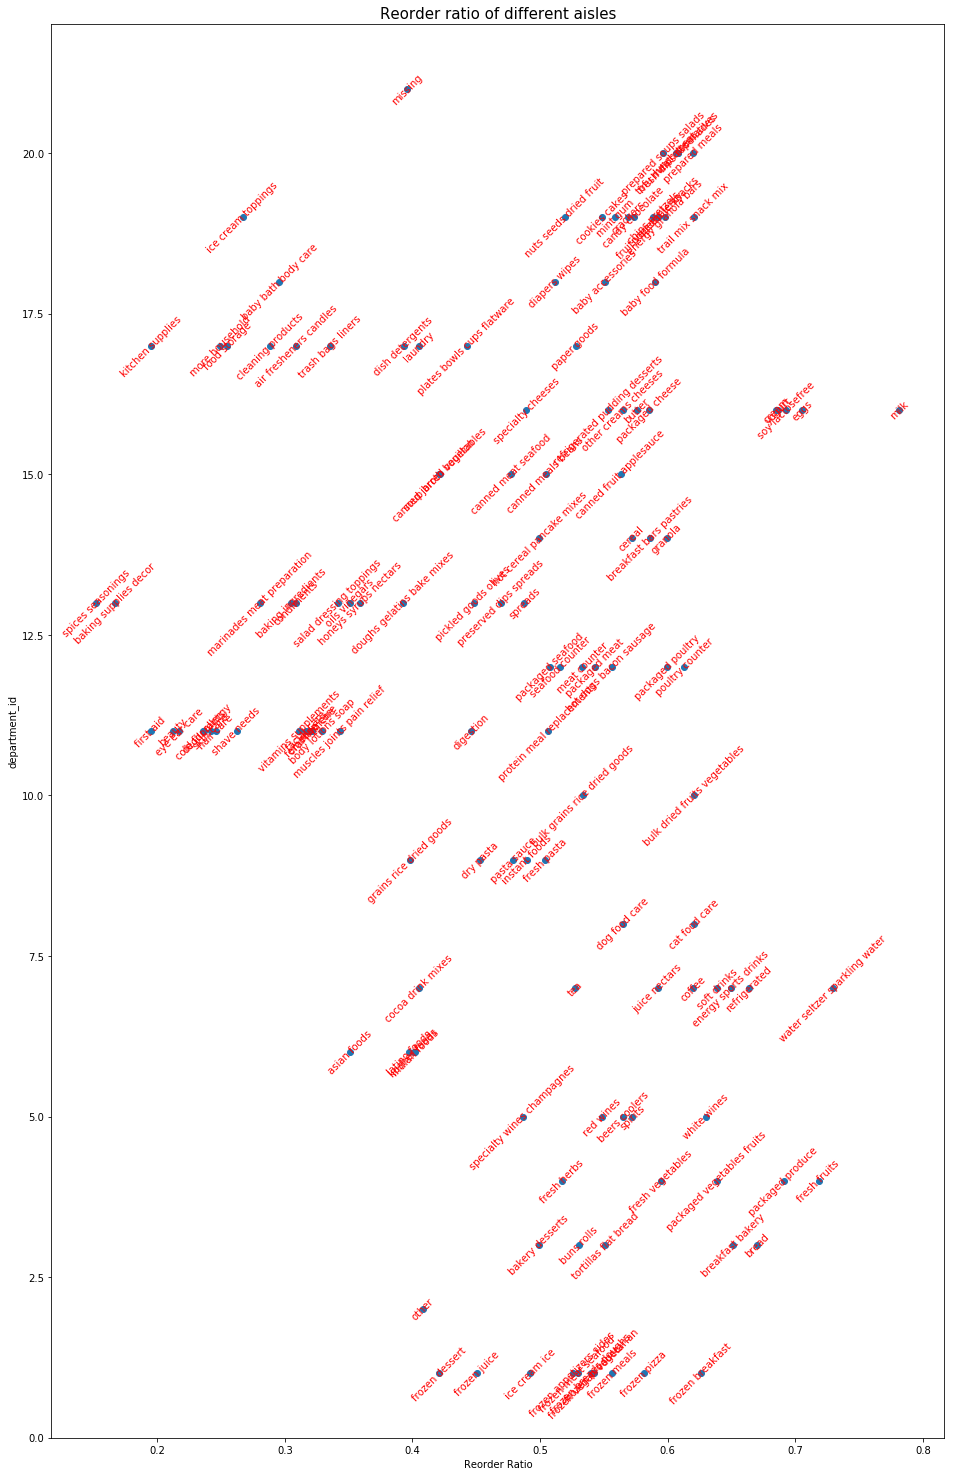

In [35]:
grouped_df = order_products_prior_df.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(16,26))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='red')
plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

## Reorder - Add to cart

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


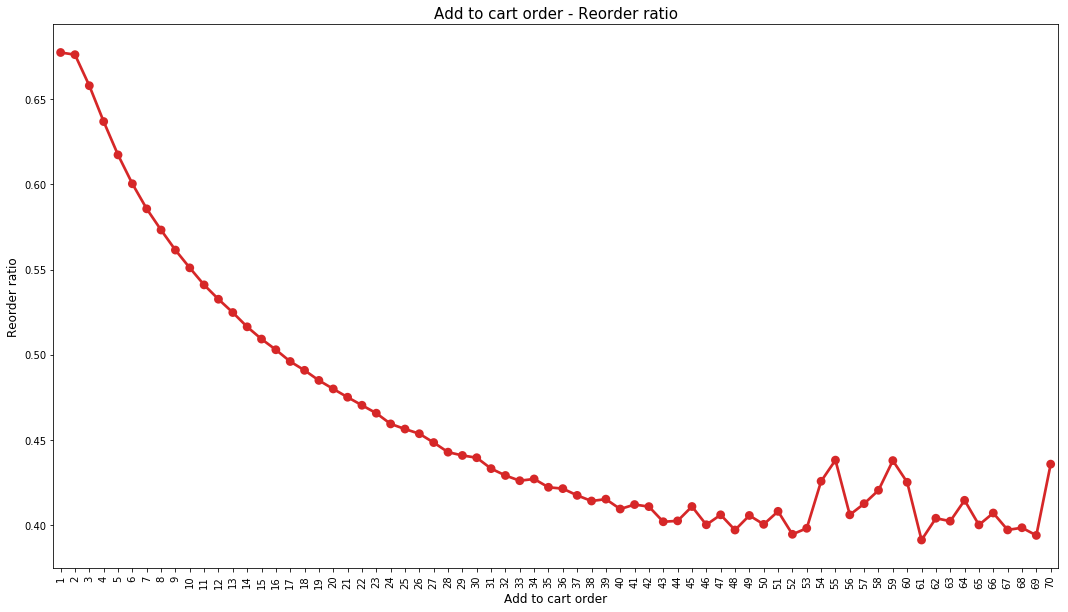

In [36]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df["add_to_cart_order_mod"].ix[order_products_prior_df["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(18,10))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

### **Looks like the products that are added to the cart initially are more likely to be reordered again compared to the ones added later.** 
This makes sense to me as well since we tend to first order all the products we used to buy frequently and then look out for the new products available.

## Reorder - per Day

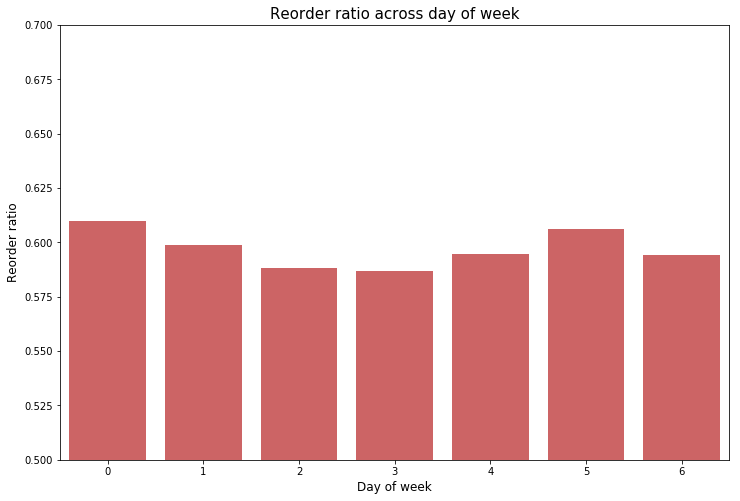

In [37]:
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.ylim(0.5, 0.7)
plt.show()

## Reorder - per Hour

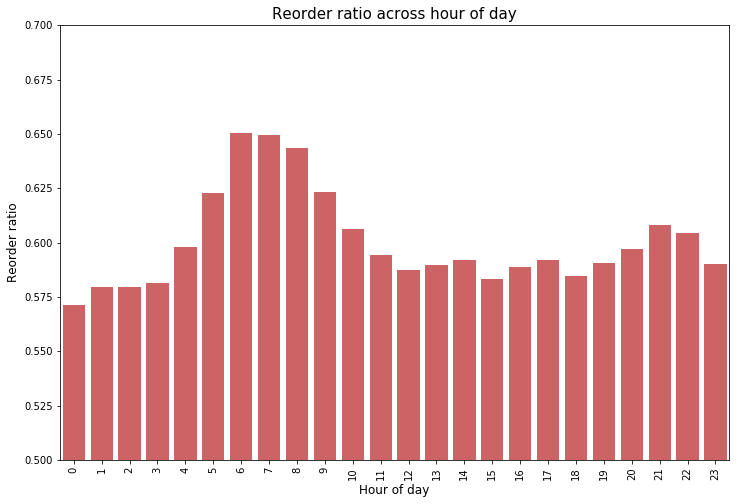

In [38]:
grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

#### Looks like reorder ratios are quite high during the early mornings compared to later half of the day.

## What customer is gonna add next?

In [39]:
df_test = orders_df.loc[orders_df['eval_set'] == 'test']
len (df_test)

75000

In [40]:
df_train = order_products_train_df.copy()
products = products_df.copy()
orders = orders_df.copy()

In [41]:
#Add a field to calculate the sum of times an item was reordered
products['rsum']=df_train.groupby('product_id')['reordered'].sum()
#Add a field to calculate the total times the item could have been reordered
products['rtotal']=df_train.groupby('product_id')['reordered'].count()
#Add a field to calculate the probability that the item was reordered
products['prob']=products['rsum']/products['rsum'].sum()
products['prob']=products['prob'].replace('0',np.nan)
products = products.dropna(how='any',axis=0)
products.head()

,product_id,product_name,aisle_id,department_id,rsum,rtotal,prob
1,2,All-Seasons Salt,104,13,49.0,76.0,0.000059
2,3,Robust Golden Unsweetened Oolong Tea,94,7,1.0,4.0,0.000001
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,6.0,6.0,0.000007
4,5,Green Chile Anytime Sauce,5,13,14.0,22.0,0.000017
5,6,Dry Nose Oil,11,11,1.0,1.0,0.000001


In [42]:
#Let's examine a subset of the products with the highest probability of reordering to see if there are any key attributes
g= products[(products.prob>0.003) & (products.rtotal>15)]
g = g.sort_values('prob',ascending=False)

In [43]:
#Add product-specific reordering probabilities to dataframe
df_train = pd.merge(left=df_train, right=products, how='left')
df_train = df_train.drop('product_name',axis=1)
df_train = pd.merge(left=df_train,right=orders,how='left')
df_train = df_train.dropna(how='any',axis=0)
df_train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id,rsum,rtotal,prob
0,1,49302,1,1,112108,train,4,4,10,9.0,120.0,16.0,1.0,3.0,0.000001
3,1,49683,4,0,112108,train,4,4,10,9.0,83.0,4.0,0.0,5.0,0.000000
4,1,43633,5,1,112108,train,4,4,10,9.0,95.0,15.0,30.0,64.0,0.000036
5,1,13176,6,0,112108,train,4,4,10,9.0,24.0,4.0,2.0,4.0,0.000002
7,1,22035,8,1,112108,train,4,4,10,9.0,21.0,16.0,16.0,138.0,0.000019


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


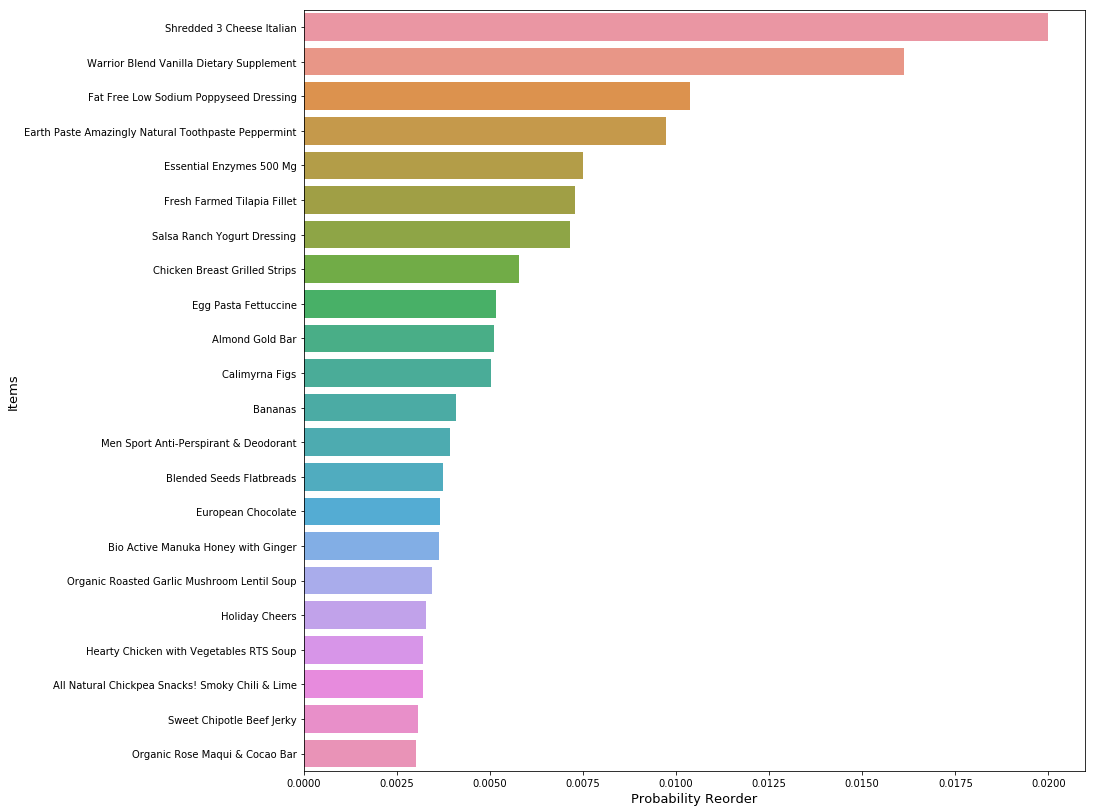

In [44]:
#Let's plot the subset of the products with the highest probabilty of reordering
plt.figure(figsize=(14,14))
fig = sns.barplot(g['prob'],g['product_name'])
# plt.xticks(rotation='vertical')
axe = plt.axes()
plt.ylabel('Items', fontsize=13)
plt.xlabel('Probability Reorder', fontsize=13)
plt.show()

In [45]:
#Get test orders and reset index
df_test = orders.loc[orders['eval_set'] == 'test']
df_test = df_test.reset_index(drop=True)
df_test.head()#Add product-specific reordering probabilities to dataframe
df_train = pd.merge(left=df_train, right=products, how='left')
df_train = df_train.drop('product_name',axis=1)
df_train = pd.merge(left=df_train,right=orders,how='left')
df_train = df_train.dropna(how='any',axis=0)
df_train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id,rsum,rtotal,prob
0,1,49302,1,1,112108,train,4,4,10,9.0,120,16,1.0,3.0,0.000001
1,1,49683,4,0,112108,train,4,4,10,9.0,83,4,0.0,5.0,0.000000
2,1,43633,5,1,112108,train,4,4,10,9.0,95,15,30.0,64.0,0.000036
3,1,13176,6,0,112108,train,4,4,10,9.0,24,4,2.0,4.0,0.000002
4,1,22035,8,1,112108,train,4,4,10,9.0,21,16,16.0,138.0,0.000019


In [46]:
# X = df_train.copy()
# X.head()

In [47]:
#Get test orders and reset index
df_test = orders.loc[orders['eval_set'] == 'test']
df_test = df_test.reset_index(drop=True)
df_test.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2774568,3,test,13,5,15,11.0
1,329954,4,test,6,3,12,30.0
2,1528013,6,test,4,3,16,22.0
3,1376945,11,test,8,6,11,8.0
4,1356845,12,test,6,1,20,30.0
